In [8]:
import os
import json
import threading
import numpy as np
import pandas as pd
import concurrent.futures
import matplotlib.pyplot as plt

from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [9]:
network_analytics = pd.read_csv('./data/Network_Analytics.csv')
series = pd.Series(network_analytics['OutboundUtilzation (%)'])

## Lets run some correlation tests

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

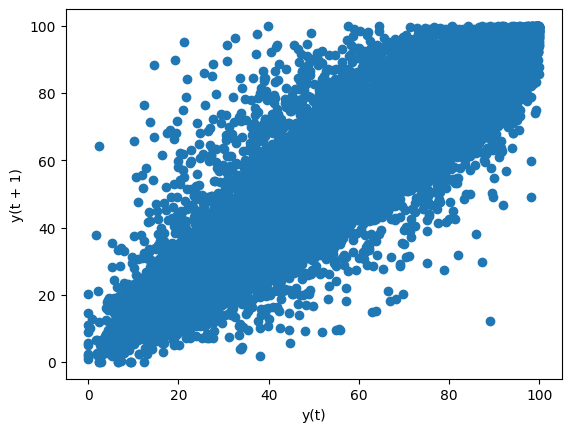

In [10]:
pd.plotting.lag_plot(series)

We can clearly see that there is some correlation in the data. Lets find the Pearson correlation coefficient.

In [11]:
from scipy.stats import pearsonr

print(pearsonr(series, series))

PearsonRResult(statistic=1.0, pvalue=0.0)


In [12]:
print(series.autocorr())

0.9229190122478931


In [13]:
r = np.correlate(series, series, mode = 'full')
print(r)

[5666.84887158 9252.88124001 9766.03146731 ... 9766.03146731 9252.88124001
 5666.84887158]


In [14]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
result = dataframe.corr()
print(result)

            t       t+1
t    1.000000  0.922919
t+1  0.922919  1.000000


The value 0.922919 tell us, that there is stong positive correlation.

Autocorrelation plot:

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

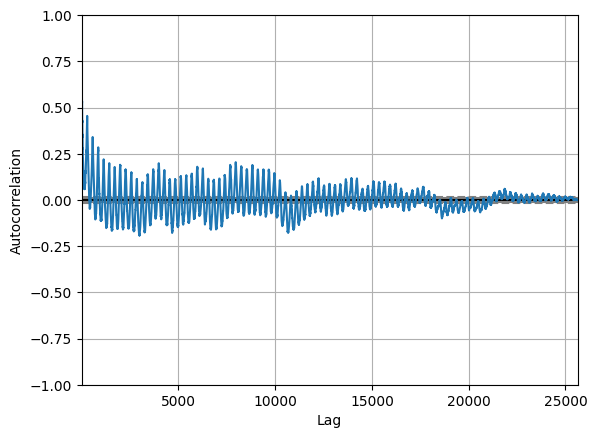

In [15]:
pd.plotting.autocorrelation_plot(series)

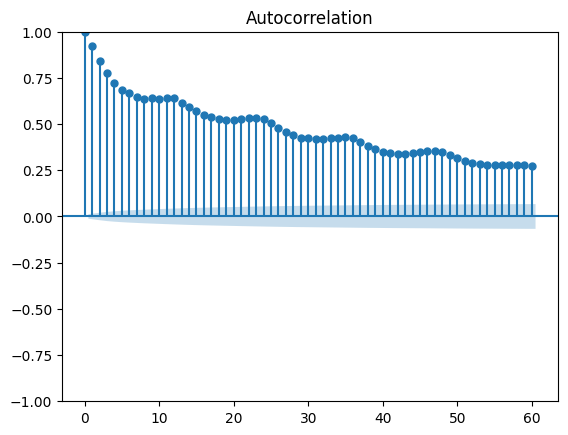

In [16]:
plot_acf(series, lags=60)
plt.show()

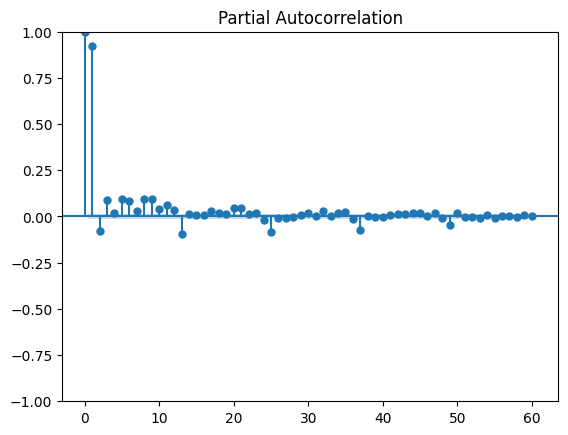

In [17]:
plot_pacf(series, lags=60)
plt.show()

In [18]:
X = series.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
print(len(train))
print(len(test))

25118
513


## Augmented Dickey-Fuller (ADF) test

In [19]:
from statsmodels.tsa.stattools import adfuller

t_stat, p_value, _, _, critical_values, _  = adfuller(X, autolag='AIC')
print(f'ADF Statistic: {t_stat:.2f}')
print(f'p-value: {p_value:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'   {key}, {value:.2f}')

ADF Statistic: -12.70
p-value: 0.00
Critial Values:
   1%, -3.43
Critial Values:
   5%, -2.86
Critial Values:
   10%, -2.57


## Ljung-Box Test and Information Criteria

In [9]:
def worker_func(id : int):
    if id % 10 == 0:
        print(f"Processing {id} by thread {threading.get_native_id()}")
    model = AutoReg(X, lags=id)
    result = model.fit()
    aic = result.aic
    bic = result.bic
    residuals = result.resid
    result = acorr_ljungbox(residuals, lags=[id])
    p_value = result.iloc[0,1]
    return id, aic, bic, p_value

In [10]:
dir = 'output/information_criteria/'
if len([name for name in os.listdir(dir) if os.path.isfile(os.path.join(dir, name))]) <= 0:
    for x in range(10, 101):
        result = []
        with concurrent.futures.ThreadPoolExecutor(threading.active_count() - 1) as e:
            fut = [e.submit(worker_func, i) for i in range(x*100 + 1, ((x + 1) * 100) + 1)]
            for r in concurrent.futures.as_completed(fut):
                result.append(r.result())

        result = sorted(result, key=lambda x : x[0])
        import json
        with open(f"{x}.json", 'w') as json_file:
            json.dump(result, json_file)

54
P Values:  [2.24416276e-29 5.37422316e-37 5.93866467e-02 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
Selected Order (p): 1


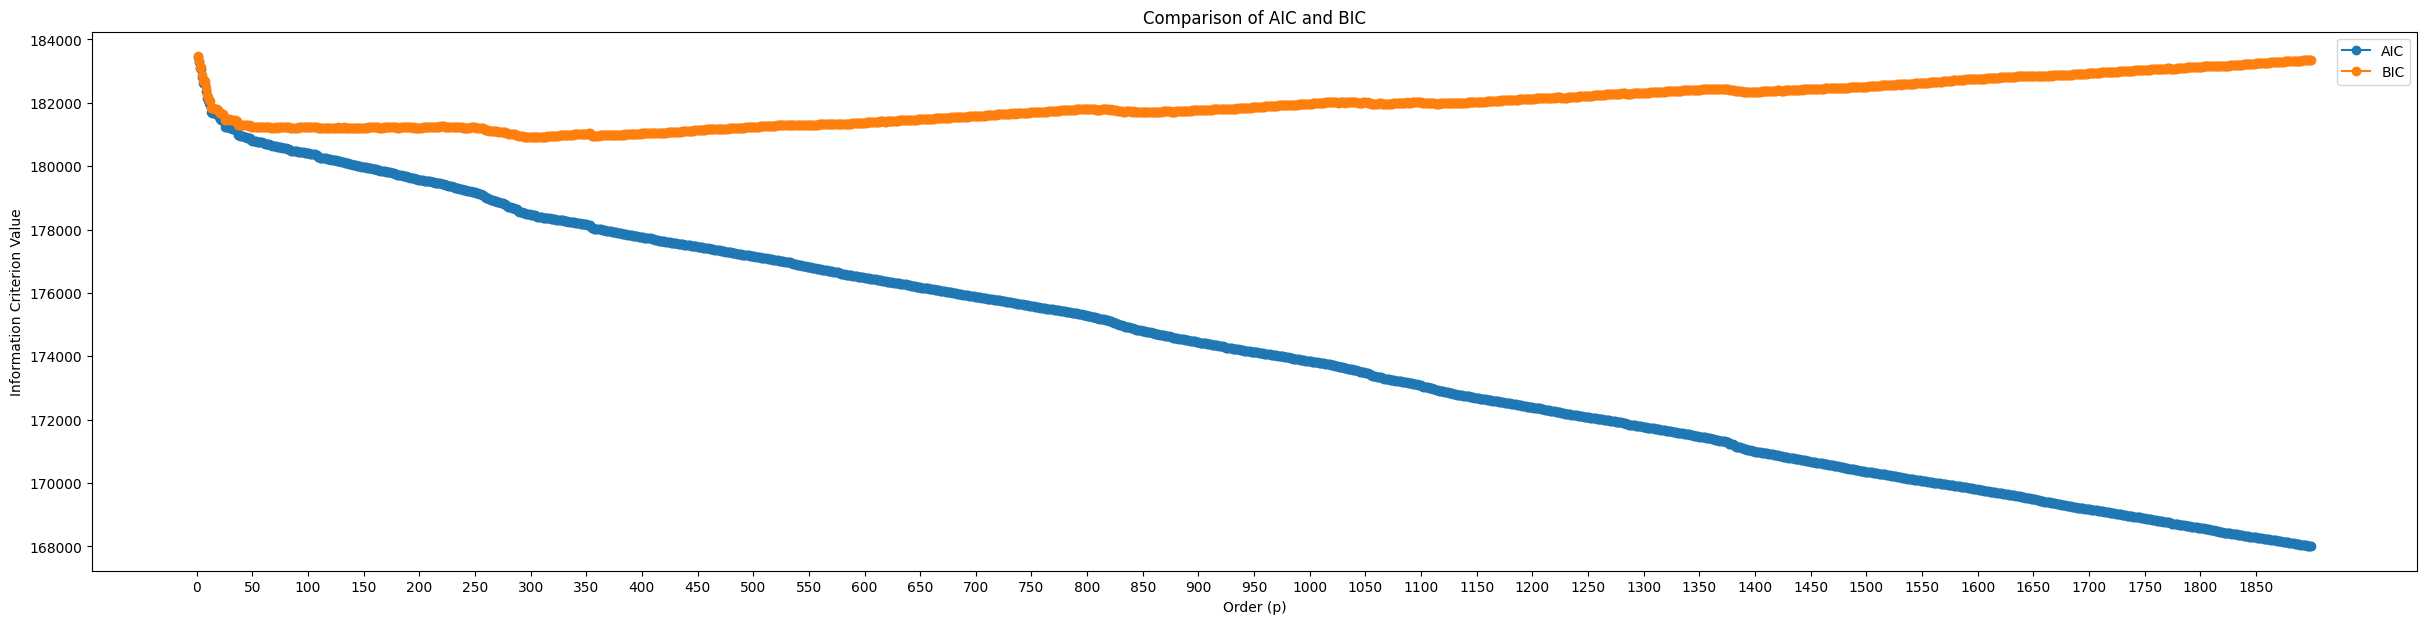

In [41]:
data = []
for file in os.listdir(dir):
    full_file_name = dir + file
    with open(full_file_name, 'r') as json_file:
        new_data = json.load(json_file)
    data.extend([dato for dato in new_data])
data = sorted(data, key=lambda x : x[0])
data = np.array(data)
aic_values = data[:,1]
bic_values = data[:,2]
p_values = data[:,3]

threshold = 0.05
selected_order = np.argmax(np.array(p_values) < threshold) + 1
first_lag = np.where(p_values == 1)
print(first_lag[0][0])
print("P Values: ", p_values)
print("Selected Order (p):", selected_order)

plt.figure(figsize=(30,7))
plt.plot(range(1, len(data) + 1), aic_values, marker='o', label='AIC')
plt.plot(range(1, len(data) + 1), bic_values, marker='o', label='BIC')
plt.xlabel('Order (p)')
plt.ylabel('Information Criterion Value')
plt.title('Comparison of AIC and BIC')
plt.xticks(np.arange(0, len(data), 50.0))
plt.legend()
plt.show()

In [68]:
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

def worker_func(lags : int):
    if lags % 10 == 0:
        print(f"Processing {lags} by thread {threading.get_native_id()}")
    model = AutoReg(train, lags=lags)
    result = model.fit()
    predictions = result.predict(start=len(train), end=len(train) + len(test) - 1)
    
    mse = mean_squared_error(test, predictions)
    return lags, mse

In [ ]:
result = []
with concurrent.futures.ThreadPoolExecutor(threading.active_count() - 1) as e:
    fut = [e.submit(worker_func, i) for i in range(1, 501)]
    for r in concurrent.futures.as_completed(fut): 
        result.append(r.result())

result = sorted(result, key=lambda x : x[0])
import json
with open(f"output/mse/mse.json", 'w') as json_file:
    json.dump(result, json_file)

Best Lag Order (p): 285


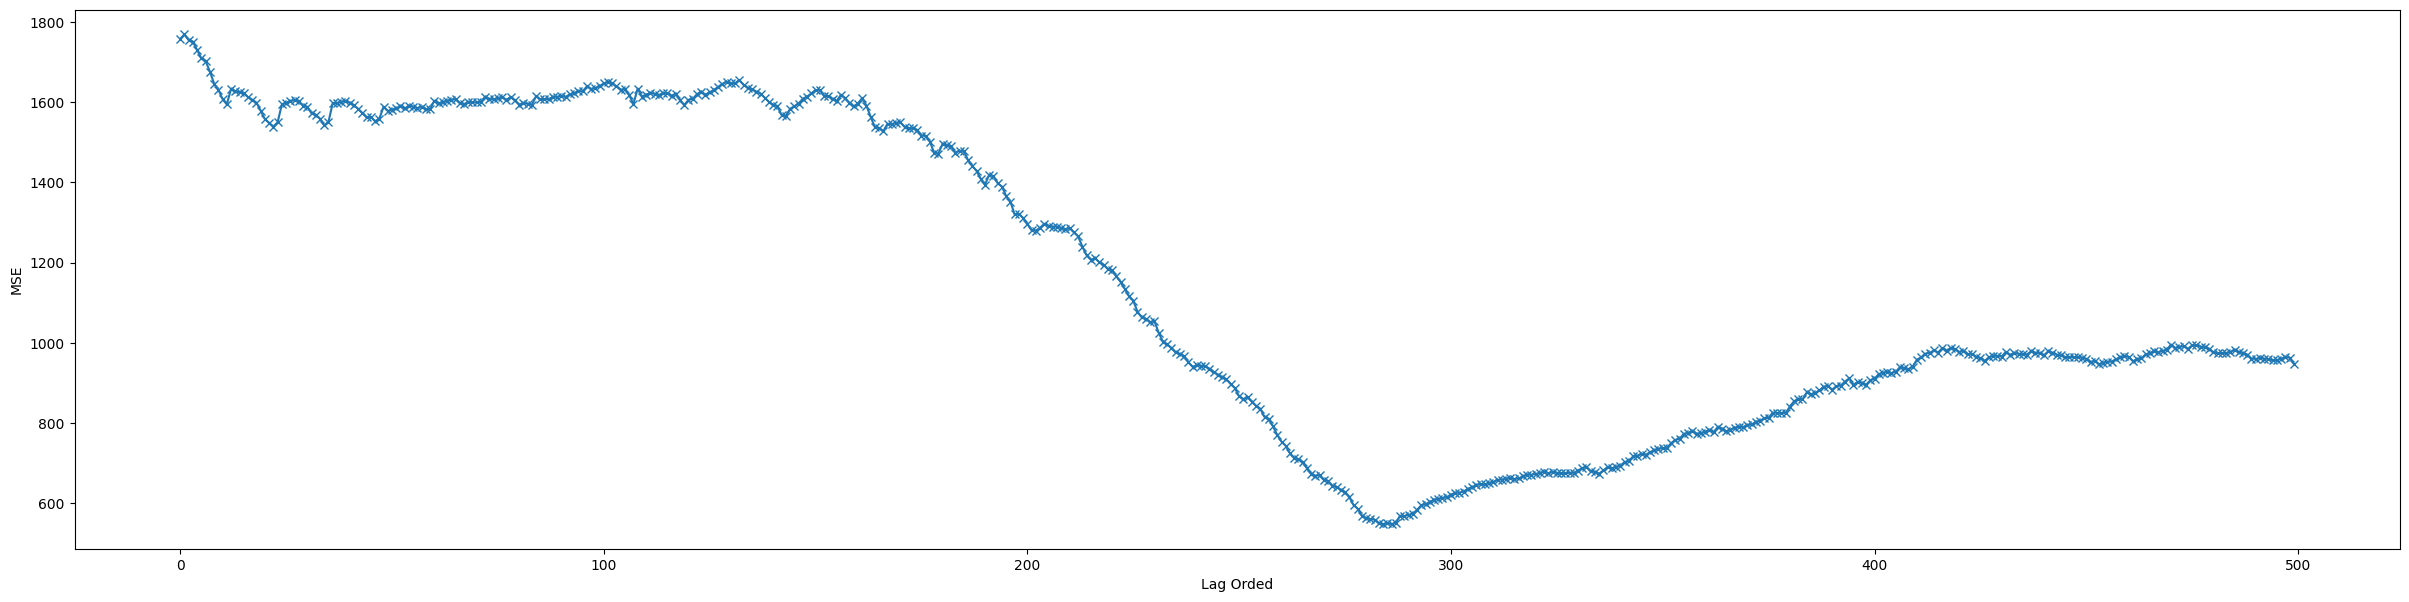

In [3]:
data = []
with open("./output/mse/mse.json", "r") as json_file:
    data = json.load(json_file)


best_order = None
best_mse = np.inf

mse_scores = []
for dato in data:
    p = dato[0]
    mse = dato[1]
    mse_scores.append(mse)

    if mse < best_mse:
        best_mse = mse
        best_order = p

print("Best Lag Order (p):", best_order)
fig, ax = plt.subplots(figsize=(30,7))
ax.set_ylabel('MSE')
ax.set_xlabel('Lag Orded')
ax.plot(mse_scores, marker='x')


In [20]:
MIN_LAGS = 285
MAX_LAGS = 286

In [21]:
def absolute_error_statistics(original : np.array, predicted : np.array):
    assert len(original) == len(predicted)
    return np.absolute(original - predicted)

In [22]:
def symmetric_mean_absolute_percentage_error(A, F):
    return 100/len(A) * np.sum(np.abs(F - A) / ((np.abs(A) + np.abs(F)) / 2))

RMSE for 285 lagged values: 36.17334391091831
MAPE for 285 lagged values: 2.965554138830416
SMAPE for 285 lagged values: 87.77317761631754
MAE for 285 lagged values: 27.832500354099075


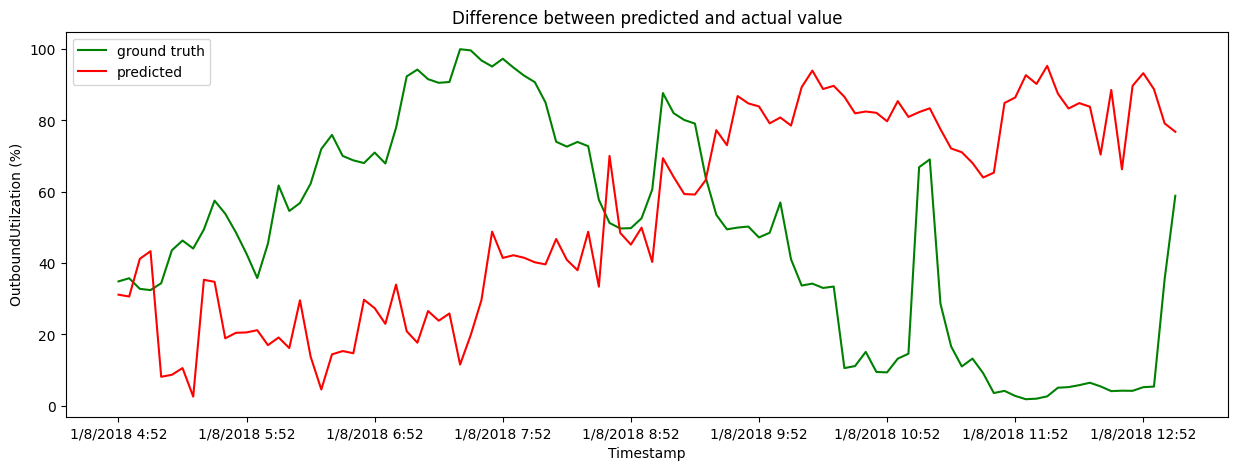

In [24]:
rmses = []
results = {}

for window in range(MIN_LAGS, MAX_LAGS):

    model = AutoReg(train, lags=window)
    model_fit = model.fit()
    coef = model_fit.params
    # walk forward over time steps in test
    history = train[len(train)-window:].tolist()
    predictions = list()
    for t in range(len(test)):
        length = len(history)
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * history[d]
            obs = X[t]
        predictions.append(yhat)
        history.pop(0)
        history.append(obs)

rmse = sqrt(mean_squared_error(test, predictions))
print(f"RMSE for {MIN_LAGS} lagged values: {rmse}")

mape = mean_absolute_percentage_error(test, predictions)
print(f"MAPE for {MIN_LAGS} lagged values: {mape}")

smape = symmetric_mean_absolute_percentage_error(test, predictions)
print(f"SMAPE for {MIN_LAGS} lagged values: {smape}")

mae = mean_absolute_error(test, predictions)
print(f"MAE for {MIN_LAGS} lagged values: {mae}")

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(network_analytics['Timestamp'][-100:], test[len(test)- 100:], color='g', label='ground truth')
ax.plot(network_analytics['Timestamp'][-100:], predictions[len(predictions) - 100:], color='r', label='predicted')
# plt.plot(series.index[len(train) - 100:len(train)], train[len(train) - 100:], color='b', label='train')
# plt.plot(series.index[len(network_analytics) - 100:], test[len(test) - 100:], color='g', label='ground truth')
# plt.plot(series.index[len(network_analytics) - 100:], predictions[len(predictions) - 100:], color='r', label='predicted')
plt.title('Difference between predicted and actual value')
plt.xticks(network_analytics['Timestamp'][-100::12])
plt.legend(loc='best')
plt.ylabel('OutboundUtilzation (%)')
plt.xlabel('Timestamp')
plt.show()

# df = pd.DataFrame(results)
# described = df.describe()

# mean = []
# fifty = []
# max_error = []

# for item in described.axes[1]:
#     mean.append(described[item]['mean'])
#     fifty.append(described[item]['50%'])
#     max_error.append(described[item]['max'])

# plt.figure(figsize=(30,7))
# plt.plot(range(MIN_LAGS, MAX_LAGS), mean, color='r', label='mean', marker='x')
# plt.plot(range(MIN_LAGS, MAX_LAGS), fifty, color='g', label='median', marker='x')
# plt.plot(range(MIN_LAGS, MAX_LAGS), max_error, color='b', label='max', marker='x')
# plt.xticks(range(MIN_LAGS, MAX_LAGS)[::10])
# plt.xlabel('Number of lags')
# plt.ylabel('Absolute error')
# plt.legend(loc='best')
# plt.show()

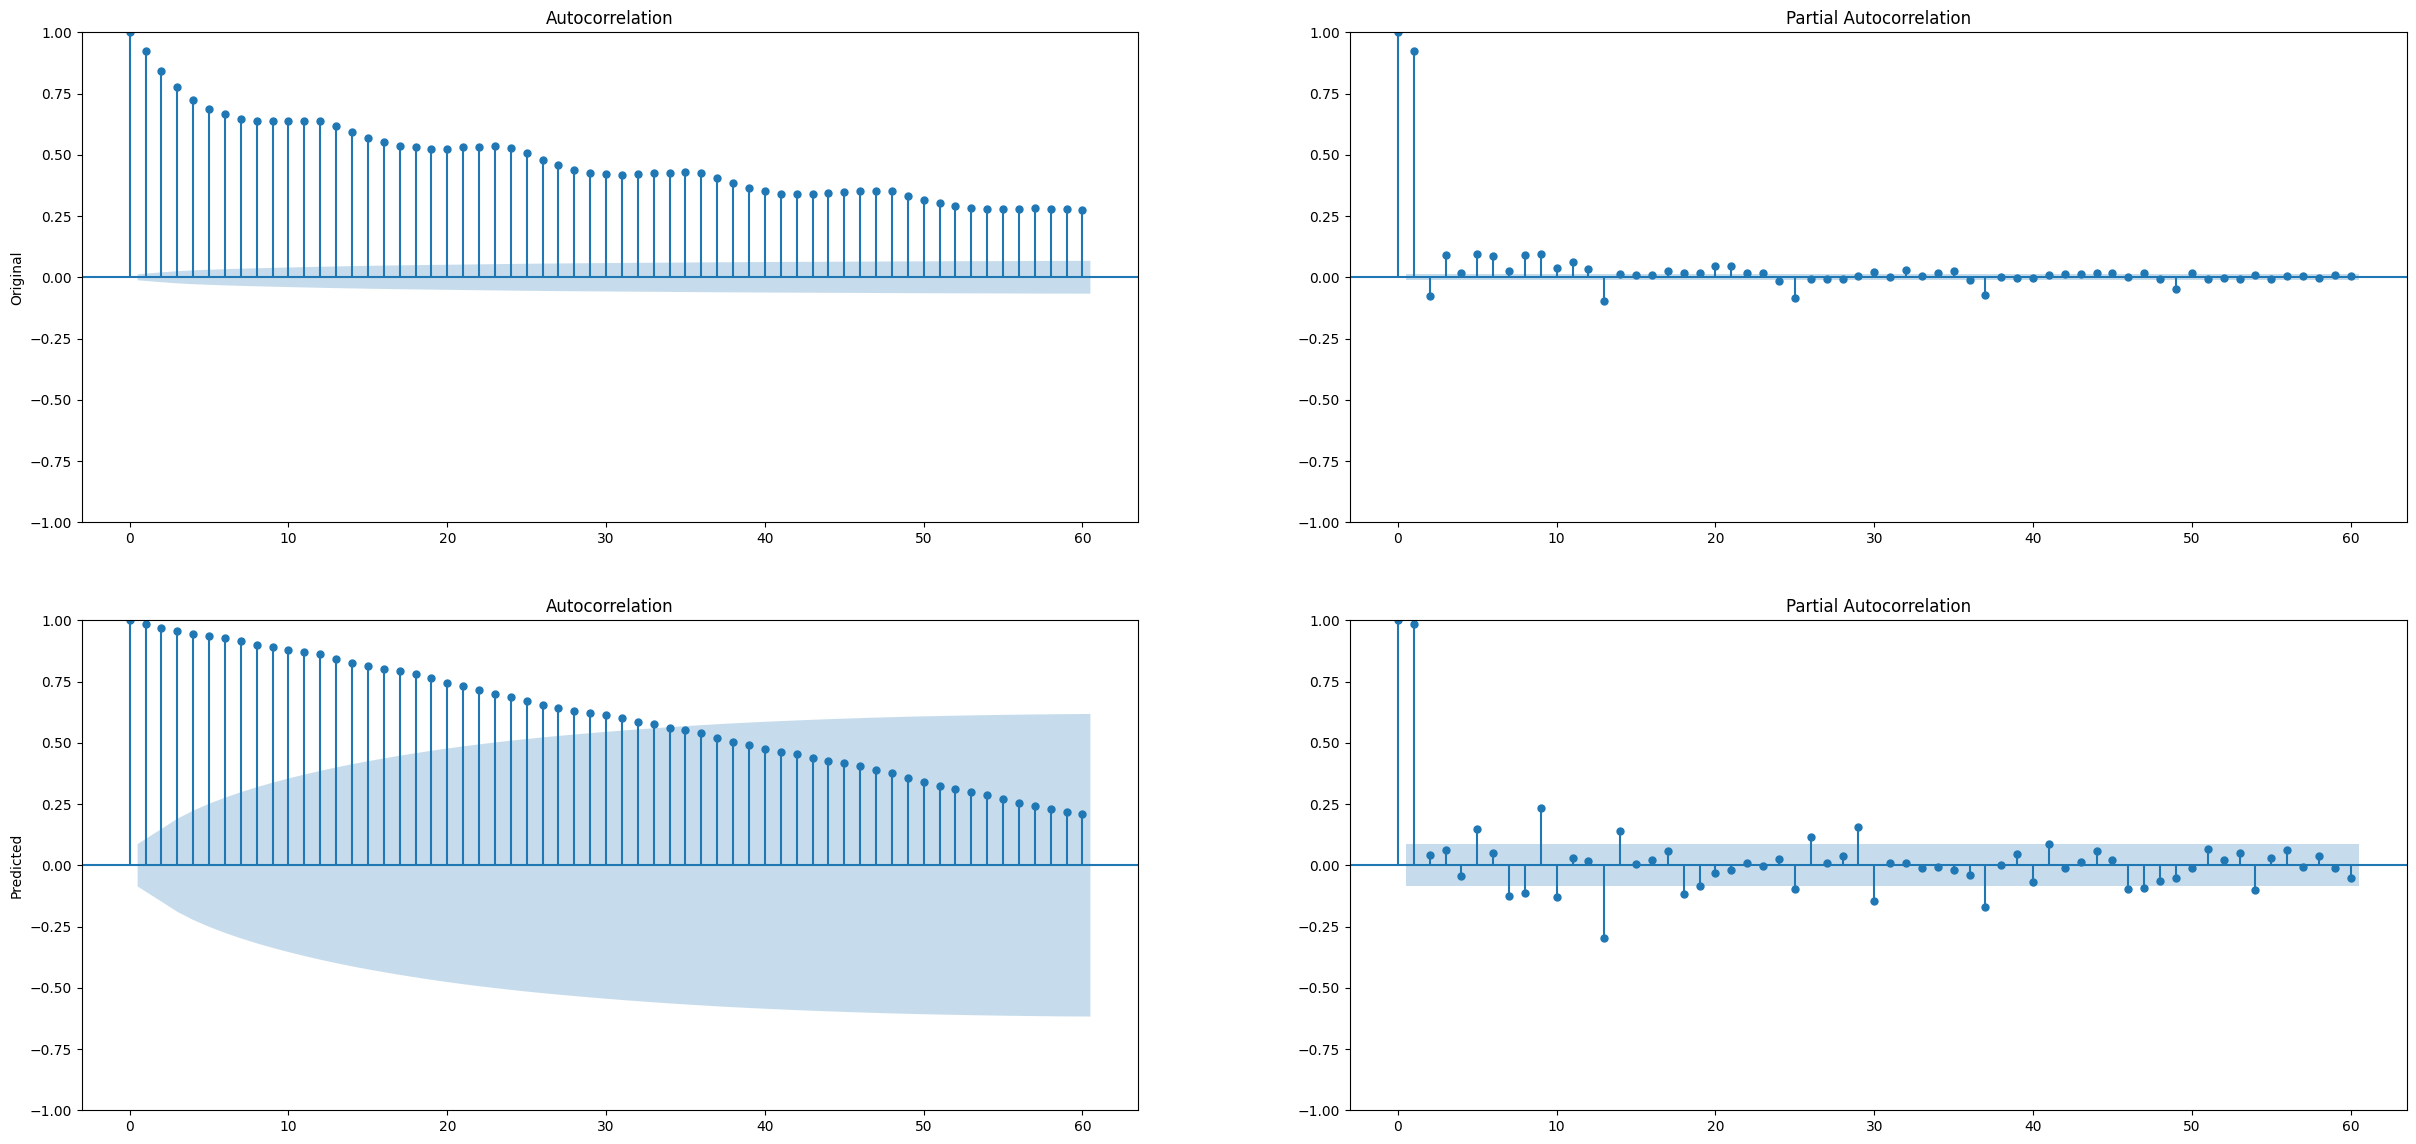

In [32]:
fig, ax = plt.subplots(2,2,figsize=(30,14))
sm.graphics.tsa.plot_acf(series, lags=60, ax=ax[0, 0])
sm.graphics.tsa.plot_pacf(series, lags=60, ax=ax[0, 1])
sm.graphics.tsa.plot_acf(predictions, lags=60, ax=ax[1, 0])
sm.graphics.tsa.plot_pacf(predictions, lags=60, ax=ax[1, 1])
ax[0, 0].set_ylabel("Original")
ax[1, 0].set_ylabel("Predicted")
plt.show()